# How is performance distributed accross zip codes?
---
### Summary
    1. Import Modules and Data
    2. Clean Data
        A. Convert/Index/Sort Data By 'datetime'
        B. Convert location zip to int
    3. Data Exploration
        A. How many zip codes do we service?
        B. How many jobs completed per zip?
        C. How much money was spent per zip?
    4. Merge Frequency df and Monetary df
    5. Rank each zip based on Frequency and Monetary value
    6. Label each zip based on rank
    7. Plot 
    8. Save Data
      
    
        


## 1. Import Modules and Data

In [103]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# disable chained assignments
pd.options.mode.chained_assignment = None

# See all data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

In [75]:
df = pd.read_csv("clean_crm_data.csv")

In [76]:
df.head(1)

,invoice_date,invoice_number,location_zip,total,completion_date
0,2021-01-15,18969046,80917.0,49.0,2021-01-15


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15673 entries, 0 to 15672
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   invoice_date     15673 non-null  object 
 1   invoice_number   15673 non-null  object 
 2   location_zip     15673 non-null  float64
 3   total            15673 non-null  float64
 4   completion_date  15673 non-null  object 
dtypes: float64(2), object(3)
memory usage: 612.4+ KB


## Clean Data

### A. Convert/Index/Sort Data By 'datetime'

In [78]:
# Convert invoice dates to pd date time
df['invoice_date'] = pd.to_datetime(df.invoice_date)

# Index DF with 'invoice_date' and sort ascending
df = df.sort_values(by='invoice_date', ascending=False)
df = df.set_index(df['invoice_date'])

In [79]:
df.dtypes

invoice_date       datetime64[ns]
invoice_number     object        
location_zip       float64       
total              float64       
completion_date    object        
dtype: object

In [80]:
df.invoice_date.min()

Timestamp('2018-06-01 00:00:00')

In [81]:
df.invoice_date.max()

Timestamp('2021-09-28 00:00:00')

### B. Convert location zip to int

In [82]:
df['location_zip'] = df.location_zip.astype(int)

In [83]:
df.dtypes

invoice_date       datetime64[ns]
invoice_number     object        
location_zip       int32         
total              float64       
completion_date    object        
dtype: object

## 3. Data Exploration

### A. How many zip codes do we service?

In [84]:
df['location_zip'].unique()

array([ 80923,  80906,  80907,  80919,  80920,  80905,  80924,  80922,
        80921,  80904,  80909,  80132,  80908,  80817,  80916,  80918,
        80903,  80106,  80925,  80831,  80911,  80109,  80917,  81001,
        80915,  80927,  80829,  80951,  80910,  80133,  80939,  80929,
        80863,  80809,  81007,  80926,  80118,  81005,  80938,  80123,
       808017,  80112,  80212,  80246,  78108,  81008,  80027,   8017,
       880951,  80937,  22205,  80928,  33308,  81006])

In [85]:
len(df['location_zip'].unique())

54

### B. How many jobs completed per zip?

In [86]:
# How many jobs were completed by zip?
frequency = df.groupby('location_zip').invoice_number.count().reset_index().sort_values('invoice_number', ascending=False)
# Update column name
frequency = frequency.rename(columns={'invoice_number': 'frequency_count'})
frequency.head()

,location_zip,frequency_count
32,80919,1653
33,80920,1641
34,80921,1309
10,80132,1268
22,80906,1236


### C. How much money was spent per zip?

In [87]:
# How much money was spent by zip?
monetary = df.groupby('location_zip').total.sum().reset_index().sort_values('total', ascending=False)
# Update column name
monetary = monetary.rename(columns={'total': 'monetary_sum'})
monetary.head()

,location_zip,monetary_sum
32,80919,489861.74
33,80920,466744.75
22,80906,449015.50
34,80921,347282.33
10,80132,311673.35


## 4. Merge df's

In [88]:
df_f_m = frequency.merge(monetary, on='location_zip')

In [89]:
df_f_m.head()

,location_zip,frequency_count,monetary_sum
0,80919,1653,489861.74
1,80920,1641,466744.75
2,80921,1309,347282.33
3,80132,1268,311673.35
4,80906,1236,449015.50


## 5. Rank each zip based on Frequency and Monetary value

In [90]:
df_f_m['f_percentile'] = df_f_m['frequency_count'].rank(method='first', pct=True,ascending=True)
df_f_m['f_score'] = pd.qcut(df_f_m['f_percentile'], 4, labels=range(4,0,-1))
df_f_m['m_percentile'] = df_f_m['monetary_sum'].rank(method='first', pct=True,ascending=True)
df_f_m['m_score'] = pd.qcut(df_f_m['m_percentile'], 4, labels=range(4,0,-1))

In [91]:
df_f_m.head(1)

,location_zip,frequency_count,monetary_sum,f_percentile,f_score,m_percentile,m_score
0,80919,1653,489861.74,1.0,1,1.0,1


In [92]:
# Drop unneeded columns
columns_drop = ['f_percentile', 'm_percentile']
df_f_m.drop(columns_drop, inplace=True, axis=1)

In [93]:
df_f_m.head(1)

,location_zip,frequency_count,monetary_sum,f_score,m_score
0,80919,1653,489861.74,1,1


In [94]:
df_f_m['score_total'] = df_f_m['f_score'].astype(int) + df_f_m['m_score'].astype(int)

In [95]:
df_f_m.head(1)

,location_zip,frequency_count,monetary_sum,f_score,m_score,score_total
0,80919,1653,489861.74,1,1,2


## 6. Label each zip based on rank

In [96]:
# Define label function
def level(df):
    if df['score_total'] == 2:
        return 'Top'
    elif ((df['score_total'] >= 3) and (df['score_total'] <= 4)):
        return 'Mid'
    elif ((df['score_total'] >= 5) ):
        return 'Low'

In [97]:
# Apply label function
df_f_m['label'] = df_f_m.apply(level, axis=1)
df_f_m.head() 

,location_zip,frequency_count,monetary_sum,f_score,m_score,score_total,label
0,80919,1653,489861.74,1,1,2,Top
1,80920,1641,466744.75,1,1,2,Top
2,80921,1309,347282.33,1,1,2,Top
3,80132,1268,311673.35,1,1,2,Top
4,80906,1236,449015.50,1,1,2,Top


## 7. Plot

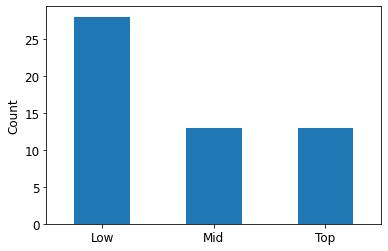

In [98]:
# Plot lables
ax = df_f_m['label'].value_counts().plot(kind='bar', fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.show()

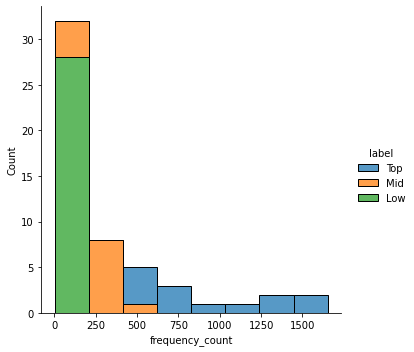

In [99]:
# Plot frequency count histogram by zip and label
sns.displot(data=df_f_m, x='frequency_count', hue="label", multiple="stack")

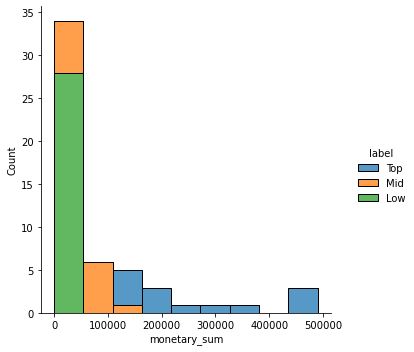

In [100]:
# Plot monetary sum histogram by zip and label. 
sns.displot(data=df_f_m, x='monetary_sum', hue="label", multiple="stack")

In [101]:
# Statistics of each group
groups = df_f_m.label.unique()
groups

for group in groups:
    base = df_f_m[df_f_m.label==group]
    describe = base.describe()[['frequency_count', 'monetary_sum']]
    print('\n', group, '\n', describe)


 Top 
        frequency_count   monetary_sum
count  13.000000        13.000000    
mean   954.000000       260733.710769
std    428.880325       139281.869094
min    426.000000       111282.800000
25%    578.000000       149281.950000
50%    822.000000       201730.410000
75%    1268.000000      347282.330000
max    1653.000000      489861.740000

 Mid 
        frequency_count   monetary_sum
count  13.000000        13.000000    
mean   236.538462       59642.432308 
std    112.938490       29209.167428 
min    61.000000        16247.900000 
25%    153.000000       37946.950000 
50%    235.000000       62986.550000 
75%    288.000000       71012.550000 
max    457.000000       113023.450000

 Low 
        frequency_count  monetary_sum
count  28.000000        28.000000   
mean   7.000000         2175.607143 
std    9.305514         3101.155241 
min    1.000000         49.000000   
25%    1.000000         115.962500  
50%    2.000000         338.000000  
75%    8.750000         3186.0500

## 7. Save Data

In [102]:
df_f_m.to_csv("zip_f_m.csv", encoding='utf-8', index=False)